In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
import os

In [2]:
archivo = fits.open('TCampo_b279.fits')
archivo.info()

Filename: TCampo_b279.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  HJD           1 ImageHDU         7   (68,)   float64   
  2  SERIES KS     1 ImageHDU         8   (68, 1280954)   float64   
  3  EKS           1 ImageHDU         8   (68, 1280954)   float64   


In [3]:
series_ks=archivo[2].data
# Inicializar un nuevo array para almacenar las medias
medias = np.zeros(series_ks.shape[0])

# Calcular la media de cada array y almacenarla en el nuevo array
for i in range(series_ks.shape[0]):
    medias[i] = np.nanmean(series_ks[i])
    
print(len(medias))

C:\Users\camil\AppData\Local\Temp\ipykernel_12256\143997432.py:7: RuntimeWarning: Mean of empty slice
  medias[i] = np.nanmean(series_ks[i])


1280954


In [4]:
# Función para calcular la MAD de una fila
def mad(fila):
    # Calcular la mediana de la fila ignorando NaN
    median = np.nanmedian(fila)
    # Calcular las desviaciones absolutas ignorando NaN
    deviations = np.abs(fila - median)
    # Calcular la mediana de las desviaciones absolutas ignorando NaN
    mad_result = np.nanmedian(deviations)
    return mad_result

# Calcular la MAD para cada fila y almacenarla en un nuevo array
mad_results = np.apply_along_axis(mad, 1, series_ks)
print(len(mad_results))

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


1280954


In [5]:
medias=np.array(medias)

# Crear un objeto HDU (Header Data Unit) de tipo ImageHDU
hdu = fits.ImageHDU(medias, name='medias')

# Crear un objeto HDUList que contiene el HDU
hdul = fits.HDUList([fits.PrimaryHDU(), hdu])

# Especificar el nombre del archivo FITS
nombre_archivo = 'Medias-Desviacion279.fits'

# Guardar el archivo FITS
hdul.writeto(nombre_archivo, overwrite=True)

# Imprimir un mensaje de confirmación
print(f"Archivo FITS creado {nombre_archivo}")

Archivo FITS creado Medias-Desviacion279.fits


In [6]:
# Convertir el array general a un array de NumPy
mad_results = np.array(mad_results)
# Especifica el nombre del archivo FITS existente
nombre_archivo_fits = 'Medias-Desviacion279.fits'

# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(nombre_archivo_fits, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(mad_results, name='mad')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: Medias-Desviacion279.fits


In [3]:
desvi = fits.open('Medias-Desviacion279.fits')
desvi.info()

Filename: Medias-Desviacion279.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  MEDIAS        1 ImageHDU         7   (1280954,)   float64   
  2  MAD           1 ImageHDU         7   (1280954,)   float64   
  3  KS_NSAT       1 ImageHDU         8   (68, 1223069)   float64   
  4  EKS_NSAT      1 ImageHDU         8   (68, 1223069)   float64   
  5  MEDIASNS      1 ImageHDU         7   (1223069,)   float64   
  6  MADNS         1 ImageHDU         7   (1223069,)   float64   
  7  Q3_EKS        1 ImageHDU         8   (68, 956867)   float64   
  8  Q3_KS         1 ImageHDU         8   (68, 956867)   float64   
  9  EQ3_EKS       1 ImageHDU         8   (68, 956867)   float64   
 10  D3_KS         1 ImageHDU         8   (68, 306755)   float64   
 11  ED3_EKS       1 ImageHDU         8   (68, 306755)   float64   


In [4]:
medias=desvi[1].data
mad_results=desvi[2].data
medias_log = np.log10(medias)
mad_log=np.log10(mad_results)
errores=archivo[3].data
# Encontrar las posiciones donde medias menor o igual a 12
posiciones_eliminar = [i for i, media_log in enumerate(medias_log) if media_log <= 1.08]

C:\Users\camil\AppData\Local\Temp\ipykernel_14300\2372938664.py:4: RuntimeWarning: divide by zero encountered in log10
  mad_log=np.log10(mad_results)


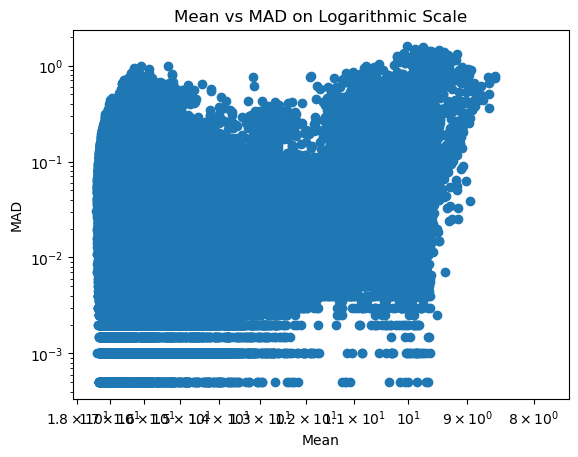

In [12]:
# Graficar los resultados con la escala ajustada en el eje x
plt.scatter(medias, mad_results)
plt.xscale('log')  # Escala logarítmica en el eje x
plt.yscale('log')  # Escala logarítmica en el eje y
plt.xticks(ticks=np.arange(18, 7, -1))  # Ajustar los ticks del eje x
plt.xlabel('Mean')
plt.ylabel('MAD')
plt.title('Mean vs MAD on Logarithmic Scale')
# Invertir el eje x
plt.gca().invert_xaxis()
plt.show()

In [8]:
medias_log = np.log10(medias)
mad_log=np.log10(mad_results)
errores=archivo[3].data
# Encontrar las posiciones donde medias menor o igual a 12
posiciones_eliminar = [i for i, media_log in enumerate(medias_log) if media_log <= 1.08]

# Eliminar las filas correspondientes de series_ks
series_ks_n = np.delete(series_ks, posiciones_eliminar, axis=0)
errores_ks_n = np.delete(errores, posiciones_eliminar, axis=0)
medias1= np.delete(medias, posiciones_eliminar, axis=0)
mad_results1 = np.delete(mad_results, posiciones_eliminar, axis=0)
print(len(series_ks_n))
print(len(errores_ks_n))

C:\Users\camil\AppData\Local\Temp\ipykernel_12256\533271882.py:2: RuntimeWarning: divide by zero encountered in log10
  mad_log=np.log10(mad_results)


1223069
1223069


In [9]:
# Convertir el array general a un array de NumPy
series_ks_n = np.array(series_ks_n)
# Especifica el nombre del archivo FITS existente
nombre_archivo_fits = 'Medias-Desviacion279.fits'

# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(nombre_archivo_fits, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(series_ks_n, name='Ks_NSat')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: Medias-Desviacion279.fits


In [10]:
# Convertir el array general a un array de NumPy
errores_ks_n = np.array(errores_ks_n)
# Especifica el nombre del archivo FITS existente
nombre_archivo_fits = 'Medias-Desviacion279.fits'

# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(nombre_archivo_fits, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(errores_ks_n, name='eKs_NSat')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: Medias-Desviacion279.fits


In [11]:
# Convertir el array general a un array de NumPy
medias1 = np.array(medias1)
# Especifica el nombre del archivo FITS existente
nombre_archivo_fits = 'Medias-Desviacion279.fits'

# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(nombre_archivo_fits, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(medias1, name='mediasNS')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: Medias-Desviacion279.fits


In [12]:
# Convertir el array general a un array de NumPy
mad_results1 = np.array(mad_results1)
# Especifica el nombre del archivo FITS existente
nombre_archivo_fits = 'Medias-Desviacion279.fits'

# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(nombre_archivo_fits, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(mad_results1, name='madNS')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: Medias-Desviacion279.fits


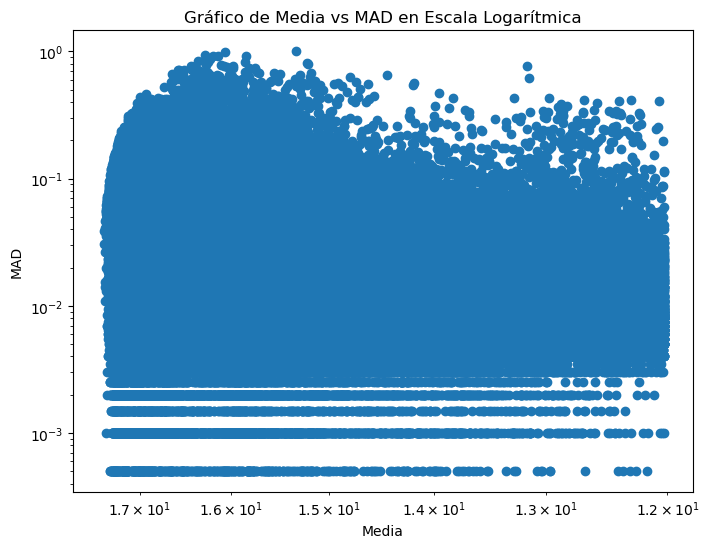

In [13]:
# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(medias1, mad_results1)
plt.xscale('log')  # Escala logarítmica en el eje x
plt.yscale('log')  # Escala logarítmica en el eje y
plt.xlabel('Media')
plt.ylabel('MAD')
plt.title('Gráfico de Media vs MAD en Escala Logarítmica')
# Invertir el eje x
plt.gca().invert_xaxis()
plt.show()

In [14]:
series_ks_n=desvi[3].data
errores_ks_n=desvi[4].data

Quantity 1: 3.0
Quantity 2 median: 22.0
Quantity 3: 57.0


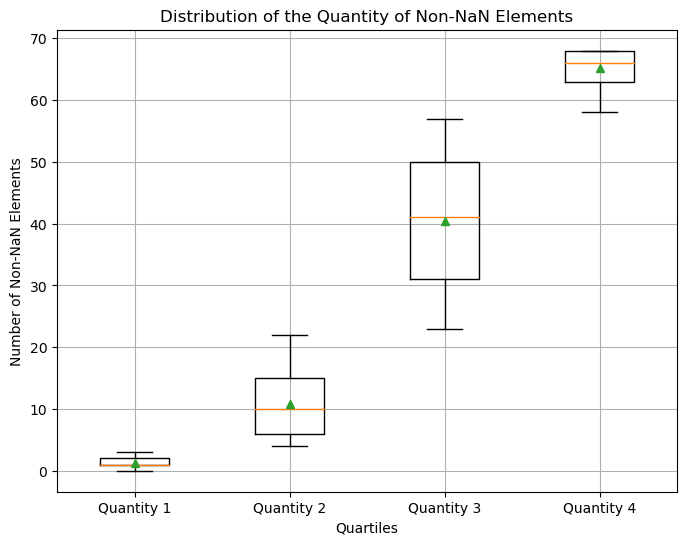

In [20]:
# Calcular la cantidad de elementos no-NaN en cada lista
cantidad_no_nan = np.sum(~np.isnan(series_ks_n), axis=1)

# Calcular los cuartiles
q1 = np.percentile(cantidad_no_nan, 25)
q2 = np.percentile(cantidad_no_nan, 50)
q3 = np.percentile(cantidad_no_nan, 75)

# Imprimir los cuartiles
print("Quantity 1:", q1)
print("Quantity 2 median:", q2)
print("Quantity 3:", q3)

# Dividir las cantidades de elementos no-NaN en cada cuartil
cuartil_1 = cantidad_no_nan[cantidad_no_nan <= q1]
cuartil_2 = cantidad_no_nan[(cantidad_no_nan > q1) & (cantidad_no_nan <= q2)]
cuartil_3 = cantidad_no_nan[(cantidad_no_nan > q2) & (cantidad_no_nan <= q3)]
cuartil_4 = cantidad_no_nan[cantidad_no_nan > q3]

# Realizar box plots para cada cuartil
plt.figure(figsize=(8, 6))
plt.boxplot([cuartil_1, cuartil_2, cuartil_3, cuartil_4], labels=['Quantity 1', 'Quantity 2', 'Quantity 3', 'Quantity 4'], showmeans=True)
plt.xlabel('Quartiles')
plt.ylabel('Number of Non-NaN Elements')
plt.title('Distribution of the Quantity of Non-NaN Elements')
plt.grid(True)
plt.show()

In [36]:
def eliminar_elementos_elimindados(series, errores):
    series_filtrado = []
    errores_filtrado = []
    for serie, error in zip(series, errores):
        if np.sum(~np.isnan(serie)) >= 57:
            series_filtrado.append(serie)
            errores_filtrado.append(error)
    return series_filtrado, errores_filtrado

# Suponiendo que tienes las listas series_ks_n y errores_ks_n
series_ks_n_filtrado, errores_ks_n_filtrado = eliminar_elementos_elimindados(series_ks_n, errores_ks_n)

print(len(series_ks_n_filtrado))
print(len(errores_ks_n_filtrado))

306755
306755


In [37]:
n_archivo='Medias-Desviacion279.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(series_ks_n_filtrado, name='D3_Ks')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: Medias-Desviacion279.fits


In [38]:
n_archivo='Medias-Desviacion279.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(errores_ks_n_filtrado, name='eD3_eKs')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: Medias-Desviacion279.fits


In [39]:
def seleccionar_subarrays_aleatorios(s, e, cantidad):
    indices_aleatorios = random.sample(range(len(s)), cantidad)
    ks_aleatorios = [s[i] for i in indices_aleatorios]
    errores_aleatorios = [e[i] for i in indices_aleatorios]
    return ks_aleatorios, errores_aleatorios

cantidad_subarrays = 100000
ks_aleatorios, errores_aleatorios = seleccionar_subarrays_aleatorios(series_ks_n_filtrado, errores_ks_n_filtrado, cantidad_subarrays)
print(len(ks_aleatorios))
print(len(errores_aleatorios))

100000
100000


In [40]:
ks_aleatorios=np.array(ks_aleatorios)

# Crear un objeto HDU (Header Data Unit) de tipo ImageHDU
hdu = fits.ImageHDU(medias, name='ks_ale')

# Crear un objeto HDUList que contiene el HDU
hdul = fits.HDUList([fits.PrimaryHDU(), hdu])

# Especificar el nombre del archivo FITS
nombre_archivo = 'PVariablesb279.fits'

# Guardar el archivo FITS
hdul.writeto(nombre_archivo, overwrite=True)

# Imprimir un mensaje de confirmación
print(f"Archivo FITS creado {nombre_archivo}")

Archivo FITS creado PVariablesb279.fits


In [41]:
errores_aleatorios=np.array(errores_aleatorios)
n1_archivo='PVariablesb279.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n1_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(errores_aleatorios, name='eKs_ale')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {n1_archivo}")

Nuevo HDU agregado al archivo FITS: PVariablesb279.fits


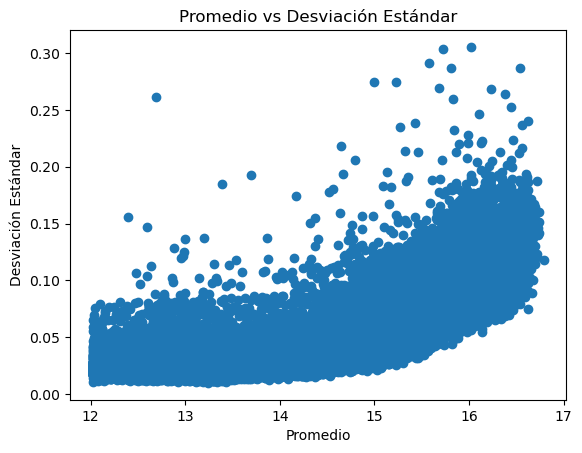

In [42]:
# Función para calcular el promedio excluyendo los NaN
def mean_without_nan(subarray):
    valid_values = [value for value in subarray if not np.isnan(value)]
    return np.mean(valid_values) if valid_values else np.nan

# Función para calcular la desviación estándar excluyendo los NaN
def std_without_nan(subarray):
    valid_values = [value for value in subarray if not np.isnan(value)]
    return np.std(valid_values) if valid_values else np.nan

# Calcula el promedio y la desviación estándar para cada subarray en ks_aleatorios
means = [mean_without_nan(subarray) for subarray in ks_aleatorios]
std_devs = [std_without_nan(subarray) for subarray in ks_aleatorios]

# Grafica la desviación estándar en el eje y y el promedio en el eje x
plt.scatter(means, std_devs)
plt.xlabel('Promedio')
plt.ylabel('Desviación Estándar')
plt.title('Promedio vs Desviación Estándar')
plt.show()

In [43]:
# Definir la función de ajuste
def funcion_ajuste(x, a, b, c):
    return a * x**2 + b * x + c  # Ejemplo de una función cuadrática
# Ajustar la función a los datos
popt, _ = curve_fit(funcion_ajuste, means, std_devs)
# Parámetros óptimos encontrados
a_opt, b_opt, c_opt = popt
# Imprimir la función de ajuste
print(f"Función de ajuste: {a_opt:.2f}x^2 + {b_opt:.2f}x + {c_opt:.2f}")

Función de ajuste: 0.01x^2 + -0.23x + 1.53


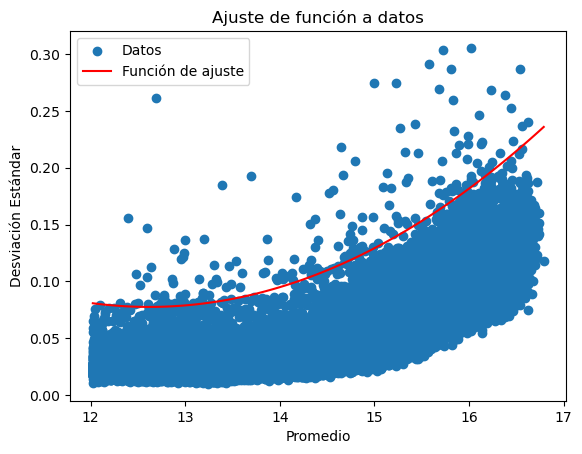

In [44]:
# Plotear los datos y la función de ajuste
plt.scatter(means, std_devs, label='Datos')
x_range = np.linspace(min(means), max(means), 100)
plt.plot(x_range, funcion_ajuste(x_range, *popt+0.0003), color='red', label='Función de ajuste')
plt.xlabel('Promedio')
plt.ylabel('Desviación Estándar')
plt.title('Ajuste de función a datos')
plt.legend()
plt.show()

In [45]:
# Convertir means a un array de NumPy si no lo es
means = np.array(means)

# Calcular los valores predichos por la función ajustada para todos los elementos de means
predicciones = funcion_ajuste(means, *popt+0.0003)

# Encontrar las posiciones donde std_devs está por encima de las predicciones
posiciones_por_encima = np.where(std_devs > predicciones)[0]

# Imprimir las posiciones por encima del ajuste
print(len(posiciones_por_encima))

181


C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


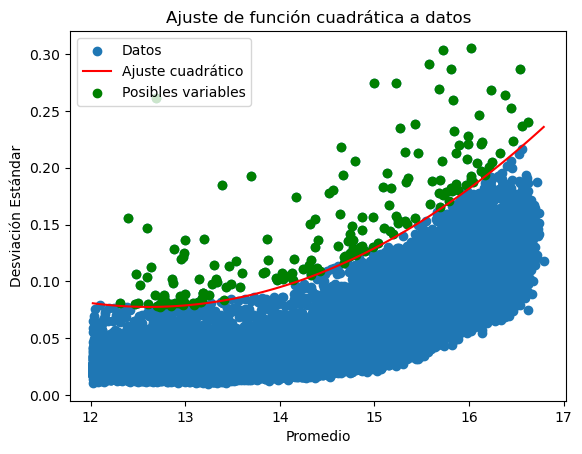

In [46]:
# Convertir means y std_devs a arrays de NumPy si no lo son
means = np.array(means)
std_devs = np.array(std_devs)

# Plotear los datos y la función de ajuste
plt.scatter(means, std_devs, label='Datos')
x_range = np.linspace(min(means), max(means), 100)
plt.plot(x_range, funcion_ajuste(x_range, *popt+0.0003), color='red', label='Ajuste cuadrático')

# Plotear las posiciones por encima del ajuste cuadrático en otro color
plt.scatter(means[posiciones_por_encima], std_devs[posiciones_por_encima], color='green', label='Posibles variables')

plt.xlabel('Promedio')
plt.ylabel('Desviación Estándar')
plt.title('Ajuste de función cuadrática a datos')
plt.legend()
plt.show()

In [47]:
# Nuevo array para almacenar la información correspondiente a las posiciones sobre el ajuste
posibles_variables = []
pv_error=[]
# Iterar sobre las posiciones por encima del ajuste
for pos in posiciones_por_encima:
    posibles_variables.append(ks_aleatorios[pos])
    pv_error.append(errores_aleatorios[pos])
# Convertir la lista de subarrays a un array de NumPy
posibles_variables= np.array(posibles_variables)
pv_error=np.array(pv_error)
print(len(posibles_variables))
print(len(pv_error))

181
181


In [48]:
n2_archivo='PVariablesb279.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n2_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(posibles_variables, name='ks_PV')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: Medias-Desviacion279.fits


In [49]:
n2_archivo='PVariablesb279.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n2_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(pv_error, name='eks_PV')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: Medias-Desviacion279.fits
